[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/044_cnn_transfer_learning/cnn_transfer_learning.ipynb)

# Transfer Learning en Redes Convolucionales

En posts anteriores hemos introducido la arquitectura de `red neuronal convolucional` y también hemos presentado varias arquitecturas famosas que han demostrado buenas prestaciones en multitud de tareas. Estas redes están formadas muchas capas convolucionales, algunas con más de 100 capas, lo cual significa que tienen muchos parámetros y entrenarlas desde cero puedes ser costoso. Sin embargo, existe una técnica que nos permite obtener buenos modelos con menores requisitos: el *transfer learning*. Ya hemos hablado anteriormente de esta técnica, en el contexto de modelos de lenguaje, pero la idea es la misma: utilizaremos el máximo número de capas de una red ya entrenada en otro dataset, y simplemente entrenaremos las nuevas capas que necesitemos para nuestra tarea concreta.

![](https://pennylane.ai/qml/_images/transfer_learning_general.png)

En este post vamos a ver cómo podemos utilizar una red neuronal pre-entrada en Imagenet, y adaptarla para una nueva tarea de clasificación con un pequeño dataset.

## El dataset

Nuestro objetivo será el de entrenar un clasificador de flores. Podemos descargar las imágenes de la siguiente url.

Una vez extraído el dataset, podemos ver que tenemos 5 clases de flores diferentes, distribuidas en 5 carpetas diferentes. Cada carpeta contiene varios ejemplos de flores de la categoría en cuestión.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os 

PATH = '/content/gdrive/MyDrive/dataset_flores'

classes = os.listdir(PATH)
classes

['tagetes', 'Hibisco', 'FlorRita', 'claveles', 'lirio']

In [3]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

Categoría: tagetes. Imágenes: 1453
Categoría: Hibisco. Imágenes: 1132
Categoría: FlorRita. Imágenes: 1186
Categoría: claveles. Imágenes: 1001
Categoría: lirio. Imágenes: 1260


Podemos visualizar algunas imágenes en el dataset.

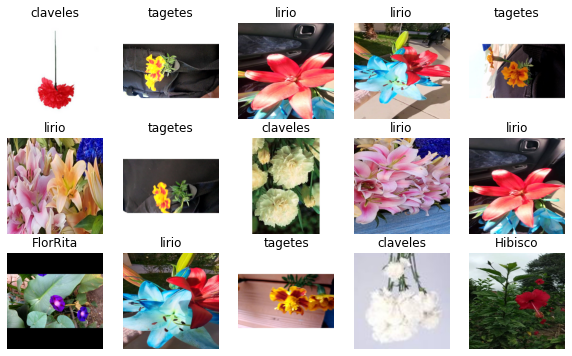

In [4]:
import random 
from skimage import io
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

Vamos a crear también un subconjunto de test para poder comparar varios modelos.

In [5]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)

(4825, 1207)

Y por último creamos nuestros objetos `Dataset` y `DataLoader` para poder darle las imágenes a nuestros modelos.

In [6]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    # aplicar transformaciones
    if self.trans:
      img = self.trans(image=img)["image"]
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

Nos aseguraremos que todas las imágenes del dataset tengan las mismas dimensiones: 224x224 píxeles.

In [7]:
import albumentations as A

trans = A.Compose([
    A.Resize(224, 224)
])

dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device), 
    'test': Dataset(test_imgs, test_labels, trans, device)
}

len(dataset['train']), len(dataset['test'])

(4825, 1207)

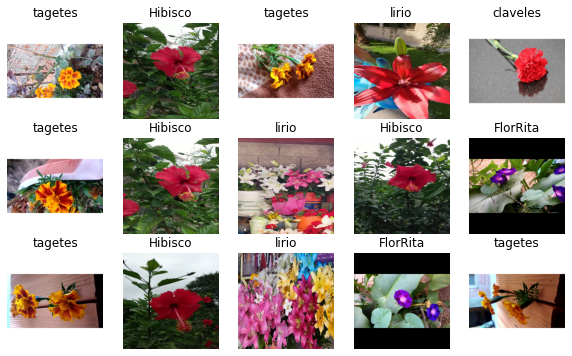

In [8]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [9]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True, pin_memory=True), 
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=256, shuffle=False)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([64, 3, 224, 224])

## El Modelo

Vamos a escoger la arquitectura `resnet`, de la que ya hablamos en el post anterior, para hacer nuestro clasificador. De este modelo usarmos todas las capas excepto la última, la cual sustituiremos por una nueva capa lineal para llevar a cabo la clasificación en 5 clases.

In [10]:
import torchvision

resnet = torchvision.models.resnet18()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
class Model(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    # descargamos resnet
    resnet = torchvision.models.resnet18(pretrained=pretrained)
    # nos quedamos con todas las capas menos la última
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(512, 5)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnet.parameters():
        param.requires_grad=True

In [12]:
model = Model()
outputs = model(torch.randn(64, 3, 224, 224))
outputs.shape

torch.Size([64, 5])

In [13]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5, lr=1e-2):
    model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

### Entrenando desde cero

En primer lugar vamos a entrenar nuestro modelo desde cero para ver qué métricas podemos obtener.

In [14]:
model = Model()
fit(model, dataloader, epochs=15)

val_loss 0.10633 val_acc 0.99000: 100%|██████████| 5/5 [03:35<00:00, 43.13s/it]


Epoch 1/15 loss 0.56285 val_loss 0.10633 acc 0.87007 val_acc 0.99000


val_loss 0.04582 val_acc 0.99266: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]


Epoch 2/15 loss 0.08188 val_loss 0.04582 acc 0.98828 val_acc 0.99266


val_loss 0.04178 val_acc 0.99844: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]


Epoch 3/15 loss 0.04296 val_loss 0.04178 acc 0.99424 val_acc 0.99844


val_loss 0.02103 val_acc 0.99687: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]


Epoch 4/15 loss 0.03092 val_loss 0.02103 acc 0.99486 val_acc 0.99687


val_loss 0.01654 val_acc 0.99766: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]


Epoch 5/15 loss 0.02387 val_loss 0.01654 acc 0.99712 val_acc 0.99766


val_loss 0.02523 val_acc 0.99375: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]


Epoch 6/15 loss 0.02052 val_loss 0.02523 acc 0.99650 val_acc 0.99375


val_loss 0.01338 val_acc 0.99687: 100%|██████████| 5/5 [00:17<00:00,  3.50s/it]


Epoch 7/15 loss 0.01589 val_loss 0.01338 acc 0.99712 val_acc 0.99687


val_loss 0.01210 val_acc 0.99766: 100%|██████████| 5/5 [00:17<00:00,  3.47s/it]


Epoch 8/15 loss 0.01288 val_loss 0.01210 acc 0.99856 val_acc 0.99766


val_loss 0.00965 val_acc 0.99687: 100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


Epoch 9/15 loss 0.01107 val_loss 0.00965 acc 0.99856 val_acc 0.99687


val_loss 0.00708 val_acc 0.99844: 100%|██████████| 5/5 [00:18<00:00,  3.61s/it]


Epoch 10/15 loss 0.00883 val_loss 0.00708 acc 0.99856 val_acc 0.99844


val_loss 0.00947 val_acc 0.99687: 100%|██████████| 5/5 [00:18<00:00,  3.62s/it]


Epoch 11/15 loss 0.00697 val_loss 0.00947 acc 0.99897 val_acc 0.99687


val_loss 0.00570 val_acc 0.99922: 100%|██████████| 5/5 [00:17<00:00,  3.53s/it]


Epoch 12/15 loss 0.00581 val_loss 0.00570 acc 0.99938 val_acc 0.99922


val_loss 0.00649 val_acc 0.99766: 100%|██████████| 5/5 [00:17<00:00,  3.54s/it]


Epoch 13/15 loss 0.00661 val_loss 0.00649 acc 0.99918 val_acc 0.99766


val_loss 0.00364 val_acc 0.99922: 100%|██████████| 5/5 [00:17<00:00,  3.46s/it]


Epoch 14/15 loss 0.00588 val_loss 0.00364 acc 0.99918 val_acc 0.99922


val_loss 0.00323 val_acc 1.00000: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]

Epoch 15/15 loss 0.00422 val_loss 0.00323 acc 0.99938 val_acc 1.00000


Como puedes ver es complicado conseguir buenas métricas ya que nuestro dataset es muy pequeño.

## Transfer Learning

Ahora vamos a entrenar el mismo caso pero, en este caso, utilizando los pesos pre-entrenados de `resnet`.

In [15]:
model = Model(pretrained=True, freeze=True)
fit(model, dataloader)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

val_loss 0.14761 val_acc 0.99687: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]


Epoch 1/5 loss 0.49564 val_loss 0.14761 acc 0.91016 val_acc 0.99687


val_loss 0.07519 val_acc 0.99922: 100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


Epoch 2/5 loss 0.11948 val_loss 0.07519 acc 0.99527 val_acc 0.99922


val_loss 0.05073 val_acc 0.99922: 100%|██████████| 5/5 [00:17<00:00,  3.53s/it]


Epoch 3/5 loss 0.07260 val_loss 0.05073 acc 0.99794 val_acc 0.99922


val_loss 0.03937 val_acc 1.00000: 100%|██████████| 5/5 [00:17<00:00,  3.56s/it]


Epoch 4/5 loss 0.05566 val_loss 0.03937 acc 0.99753 val_acc 1.00000


val_loss 0.03108 val_acc 1.00000: 100%|██████████| 5/5 [00:17<00:00,  3.53s/it]

Epoch 5/5 loss 0.04172 val_loss 0.03108 acc 0.99794 val_acc 1.00000
